## Clasificación de la calidad del aire: Random Forest Classifier

Para resolver el caso empezamos importando las librerías de pyhton necesarias para el tratamiento de los datos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

A continuación cargamos los datos desde el archivo train.csv que descargamos del sitio web de NUWE:

In [2]:
aire = pd.read_csv('train.csv', header=0, sep=';')
aire.sample(n=10, random_state=7) # muestra aleatoria de 10 filas

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
374,-3.195570,0.800716,-0.370576,0.343469,1.937200,-1.531478,-0.239130,-0.332981,2
1831,-0.579111,-0.108525,2.073138,0.111519,1.228051,-1.569219,-1.348844,-1.950082,2
1729,-0.774488,-0.274123,2.674847,-1.030168,2.620593,-3.193383,-0.655842,0.523616,2
1077,0.011571,0.092291,2.605229,-0.603635,1.594793,-1.841064,-0.263589,-0.188281,2
658,-2.207240,-1.151157,-0.767760,-0.156083,1.594157,-2.454830,1.874366,-0.268285,1
817,1.916851,-2.886353,-0.185550,0.898324,-2.088357,0.252065,-0.150879,0.466053,1
1252,-2.448060,-0.178863,-1.633241,-1.932234,2.858237,-3.017675,-0.117973,-0.335038,1
574,1.783167,1.372243,-1.442713,0.599314,-2.594346,3.843636,-0.781897,-0.870015,0
1306,-1.864162,-1.372817,-1.848298,1.837076,-0.810781,0.002618,-0.118482,0.024688,1
200,-0.002216,0.532996,0.312899,0.335000,-0.195581,0.541917,-0.777629,0.198376,2


### Análisis descriptivo de los datos

In [3]:
aire.describe().T

,count,mean,std,min,25%,50%,75%,max
feature1,2100.0,-0.318846,1.575061,-5.031501,-1.406249,-0.431219,0.773896,5.388387
feature2,2100.0,0.005348,1.605428,-6.004578,-1.119150,-0.162577,1.127450,7.663112
feature3,2100.0,-0.327567,1.479745,-5.470794,-1.368208,-0.532158,0.573801,4.869581
feature4,2100.0,0.024042,1.548154,-5.296172,-1.083716,0.152545,1.173172,4.318758
feature5,2100.0,0.085851,1.788543,-5.719499,-1.136441,0.102788,1.507492,6.033273
feature6,2100.0,-0.065000,2.124337,-4.910575,-1.613267,-0.431328,1.162813,7.053420
feature7,2100.0,-0.025603,1.015619,-3.850552,-0.701442,-0.007598,0.665932,4.400697
feature8,2100.0,-0.004437,1.003342,-3.541608,-0.659096,-0.019797,0.667530,3.579874
target,2100.0,0.985238,0.815098,0.000000,0.000000,1.000000,2.000000,2.000000


In [4]:
aire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   feature7  2100 non-null   float64
 7   feature8  2100 non-null   float64
 8   target    2100 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 147.8 KB


In [5]:
print(f'Numero de NaNs: {aire.isnull().sum().sum()}')

Numero de NaNs: 0


In [6]:
print(f'Numero de filas duplicadas: {aire.duplicated().sum()}')

Numero de filas duplicadas: 0


Hay 8 variables numéricas  independientes o features que corresponden a las lecturas de cada sensor, y una variable dependiente o target que clasifica la calidad del aire en función de estas lecturas.

Los valores de los features estan en la misma escala, en el rango (-7; 8) aprox por lo que no haría falta escalar. Tienen media y desvio estandar similares.

Los datos parecen estar bastante "limpios y ordenados", no hay NaN's ni filas duplicadas en las 2100 filas que tiene el dataset.

Con respecto a la variable target:

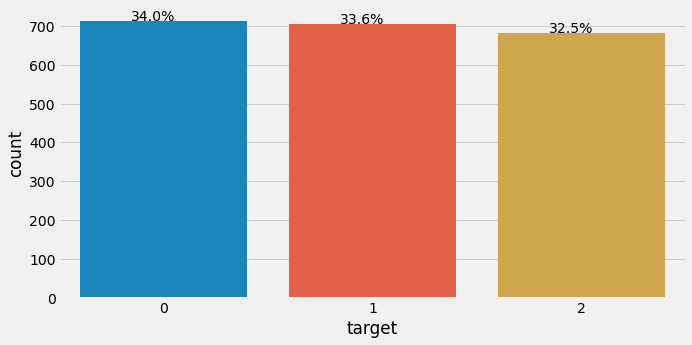

In [7]:
plt.figure(figsize = (10,5))
ax = sns.countplot(data=aire, x='target', order=aire.target.value_counts().index)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(aire))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y),ha='center')
plt.show()

In [8]:
aire.target.value_counts()*100/aire.target.value_counts().sum()

0    33.952381
1    33.571429
2    32.476190
Name: target, dtype: float64

La variable target esta equilibrada entre las distintas clases, tenemos un ~20% de cada uno de los casos.

Separaremos en un dataframe la variable target del resto de los features y analizaremos como se comportan unos y otros:

In [9]:
x = aire.drop(['target'], axis='columns')
y = pd.DataFrame(aire.target)

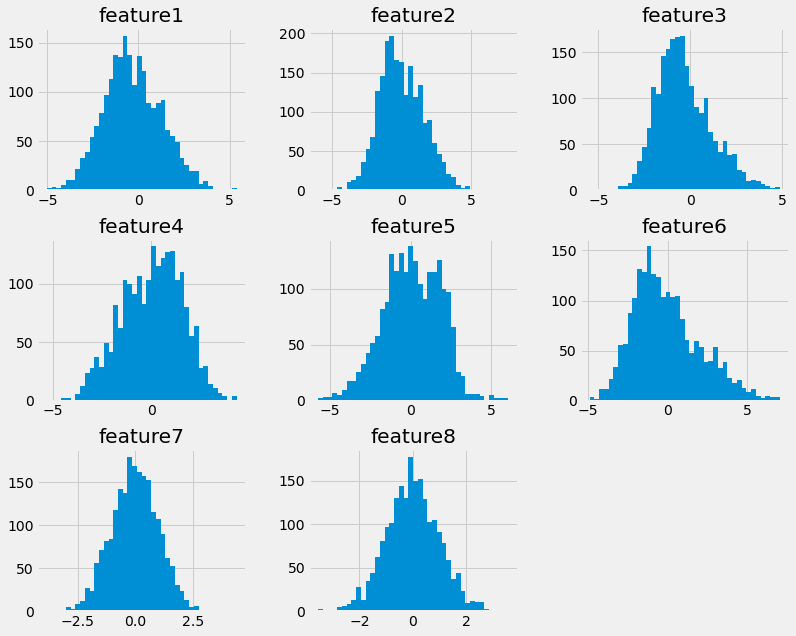

In [10]:
x.hist(bins=40, figsize=(12, 10))
plt.show()

Como habiamos dicho previamente, las variables independientes tienen su valor medio en 0 y parecen seguir una distribución normal.

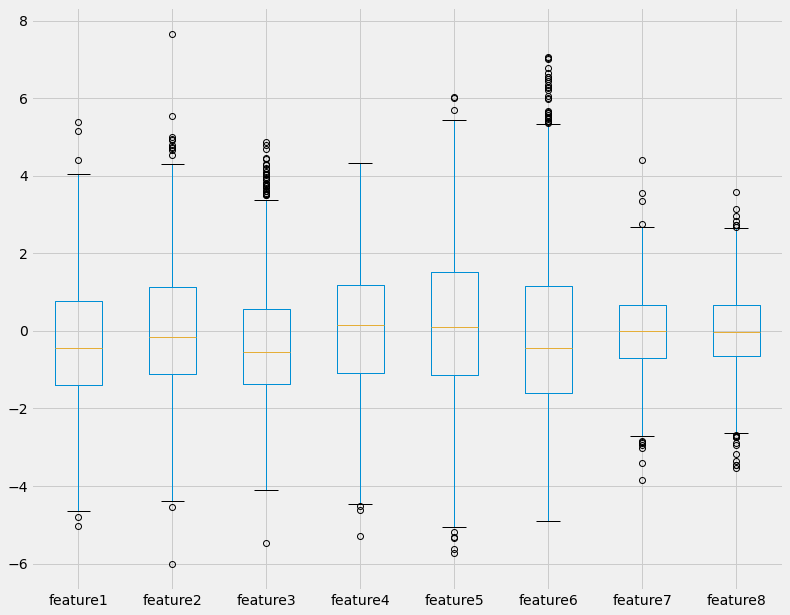

In [11]:
plt.figure(figsize = (12,10))
x.boxplot()
plt.show()

No parece que haya un problema de outliers o valores atipicos ya que interpreto que son valores posibles de lectura de los sensores (true outliers).

Veamos a continuación como se correlacionan las variables entre si:

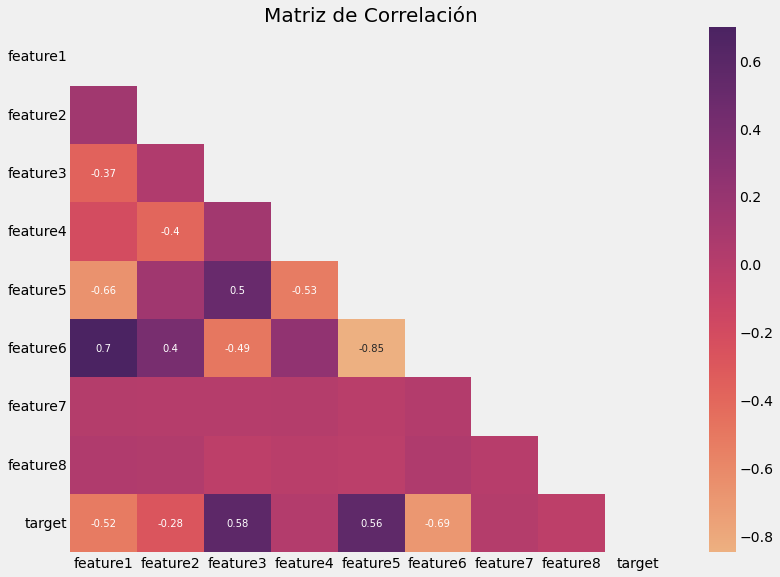

In [12]:
aire_corr = aire.corr()

mask = np.triu(np.ones_like(aire_corr, dtype = bool)) # mask the upper triangle, easier to read
fig, ax = plt.subplots(figsize = (12, 9))

sns.heatmap(aire_corr, mask = mask, cmap = 'flare', annot = True, annot_kws = {"size": 10})

for t in ax.texts:
    if float(t.get_text()) >= 0.25: # if the value is greater than 0.1 then I set the text 
        t.set_text(t.get_text()) 
    elif float(t.get_text()) <= -0.25: # if the value is smaller than -0.1 then I set the text 
        t.set_text(t.get_text())
    else:
        t.set_text("") # if not it sets an empty text

plt.title('Matriz de Correlación', fontsize = 20)
plt.show()

Vemos que hay buena correlación entre feature excepto para el 7 y el 8.

### Modelizado de los datos

Primero dividimos la muestra entre datos para entrenamiento y datos para evaluación y obtención de metricas de performance del modelo:

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=7)  # 80%-20% proportion

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1575, 8), (525, 8), (1575, 1), (525, 1))

Utilizamos el algoritmo de Random Forest Classifier para multiclases con los parametros por defecto:

In [15]:
from sklearn.ensemble import RandomForestClassifier

#instantiate RandomForestClassifier()
model = RandomForestClassifier(random_state=7)


#fit the classification
model.fit(x_train, np.ravel(y_train))

#Predict on test
y_pred = model.predict(x_test)

Matriz de confusión

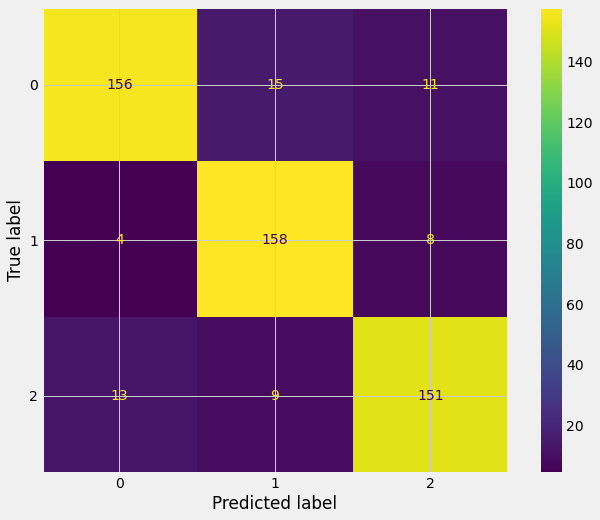

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import accuracy_score,f1_score,classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       182
           1       0.87      0.93      0.90       170
           2       0.89      0.87      0.88       173

    accuracy                           0.89       525
   macro avg       0.89      0.89      0.89       525
weighted avg       0.89      0.89      0.89       525



In [18]:
round(f1_score(y_test, y_pred, average='macro'),2)

0.89

El modelo arroja un f1_score (macro) de 0,89 lo cual no esta mal. Veremos si podemos obtener mejores metricas ajustando los parámetros:

In [19]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro') # metrica a optimizar

In [39]:
from sklearn.model_selection import GridSearchCV

# Parameters combination (Random Forest)
parameters = {"n_estimators": [100, 300, 500], "min_samples_leaf": [1, 10, 20], 'max_depth': [None, 10, 30], 
              "min_samples_split": [2, 5, 10], "criterion":["entropy","gini"], "bootstrap": [True, False]}

# create and instantiate grid search
grid = GridSearchCV(model, parameters, cv=5, scoring=f1) # 5 splits cross validation

#fit the model
grid.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 10, 30],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring=make_scorer(f1_score, average=macro))

In [40]:
print(f'Best parameters combination: {grid.best_params_}')

Best parameters combination: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [41]:
#instantiate RandomForestClassifier()
model2 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=5, 
                                bootstrap=False, criterion='entropy')

#fit the classification
model2.fit(x_train, np.ravel(y_train))

#Predict on test
y_pred2 = model2.predict(x_test)

In [42]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       182
           1       0.87      0.93      0.90       170
           2       0.87      0.86      0.86       173

    accuracy                           0.88       525
   macro avg       0.88      0.88      0.88       525
weighted avg       0.88      0.88      0.88       525



In [43]:
round(f1_score(y_test, y_pred2, average='macro'),2)

0.88

Hemos obtenido 0,88 en el f1_score por lo tanto el ajuste de parametros ha reportado un leve retroceso.

Hare una prueba ahora aplicando algunas tecnicas de ingeniería de variables:

In [44]:
aire1 = aire # hago una copia para no modificar el dataframe original

Eliminamos los outliers:

In [45]:
from collections import Counter

#drop the label 
outlier_list = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8'] 

def detect_outlier(df,feature):
    
    outlier_indices = []
    
    for f in feature:
        
        #lower quartile
        q1 = np.percentile(df[f],25)
        
        #upper quartile
        q3 = np.percentile(df[f],75)
        
        #interquartile range
        iqr = q3-q1
        
        #with coefficient
        with_coef = 1.5*iqr
        
        #detect outlier(s)
        lower_rule = q1-with_coef
        upper_rule = q3+with_coef
        
        outlier_variable = df[(df[f]<lower_rule) | (df[f]>upper_rule)].index
        outlier_indices.extend(outlier_variable)
    
    #converting to amount
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i,v in outlier_indices.items() if v>2)
    
    return multiple_outliers

 
#drop outliers
aire1 = aire1.drop(detect_outlier(aire1, outlier_list), axis=0).reset_index(drop=True)

In [46]:
aire1.shape

(2097, 9)

Solo se han eliminado 3 filas. Ahora normalizaremos las variables y luego haremos relaciones polinomicas:

In [48]:
x1 = aire1.drop(['target'], axis='columns')
y1 = pd.DataFrame(aire1.target)

In [49]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)
x1 = poly.fit_transform(x1)
x1 = pd.DataFrame(data=x1)

x1.shape

(2097, 495)

In [50]:
from sklearn.preprocessing import MinMaxScaler

x1= pd.DataFrame(MinMaxScaler().fit_transform(x1))

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(.95) #95% of the variance is retained
# x1 = pca.fit_transform(x1)
# x1 = pd.DataFrame(data=x1)

In [ ]:
# pca_expl = pca.explained_variance_ratio_.round(3) # how much variance exlains each PCA column
# pca_expl

In [51]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.25, random_state=7)

In [52]:
#instantiate RandomForestClassifier()
model3 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=5, 
                                bootstrap=False, criterion='entropy')

#fit the classification
model3.fit(x_train1, np.ravel(y_train1))

#Predict on test
y_pred3 = model3.predict(x_test1)

In [53]:
round(f1_score(y_test1, y_pred3, average='macro'),2)

0.88

Luego de probar con diferentes técnicas de ingenieria de variables (feature engineer) no se consigue aumentar el f1_score.

Finalmente haremos la clasificación de los datos presentes en el archivo "test.cvs" y la guardaremos en el archivo predicted.csv y predicted.json:

In [54]:
aire_predict = pd.read_csv('test.csv', header=0, sep=';')

In [55]:
aire_predict_pred = model.predict(aire_predict)

In [56]:
pd.DataFrame(aire_predict_pred, columns=['predicted']).to_json("predictions.json", orient='columns')
pd.DataFrame(aire_predict_pred, columns=['predicted']).to_csv("predictions.csv", index=False)